In [ ]:
# This Notebook is Part-III, where we are building the Model, will train it and save for
# testing it. The saved Model can be loaded, so will not require to build it again.
# It includes Batch processing of data to train and test, hence would not overload the Server.

**Future work:**
1.   The data pre-processing before Training the Model has to be incorporated, which will further improve the Accuracy of model. The focus was more on developing the skeleton to handle large dataset of reviews.
2.   Currently the Model is trained with 1 epoch, so the Model can be trained with more epochs, that also will further enhance the Accuracy.

In [1]:
# mount the drive in case it's not mounted already
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Paths for the files
file_path = '/content/drive/My Drive/CloudxLab/embeddings.csv'
train_file_path = '/content/drive/MyDrive/CloudxLab/df_train.csv'

In [3]:
# get the libraries imported
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical


In [ ]:
# we can have separate function for the Model to be Built, and will use simpler way of
# of creating Artificial Neural Network
def build_model(input_dim, num_classes):
    model = Sequential([
        Dense(512, activation='relu', input_dim=input_dim),
        Dense(256, activation='relu'),
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [ ]:
# a separate function is good to have for Training the Model, and we are doing
# it in incremental way while the data is being read in Batches
def train_model_in_batches(train_file_path, batch_size=10000, num_epochs=1):
    # Initialize the model
    input_dim = 512  # Number of features (embeddings have 512 dimensions)
    num_classes = 5  # Number of classes for ratings 1 to 5
    model = build_model(input_dim, num_classes)
    counter = 0
    # Read the file in chunks and train the model
    for chunk in pd.read_csv(train_file_path, chunksize=batch_size, header=None):
        # Identify and clean the ratings column
        chunk_ratings = chunk.iloc[:, -1]

        # Convert ratings to numeric, coercing errors to NaN
        chunk_ratings = pd.to_numeric(chunk_ratings, errors='coerce')

        # Remove rows with NaN ratings
        chunk = chunk[chunk_ratings.notna()]
        chunk_ratings = chunk_ratings[chunk_ratings.notna()]

        # Extract embeddings and ratings after cleaning
        chunk_embeddings = chunk.iloc[:, :-1].values
        chunk_ratings = chunk_ratings.astype(int) - 1

        # Convert ratings to categorical
        chunk_ratings_categorical = to_categorical(chunk_ratings, num_classes=num_classes)

        # Train the model on the current batch
        model.fit(chunk_embeddings, chunk_ratings_categorical, epochs=num_epochs, batch_size=batch_size, verbose=1)
        counter += 1
        print('this is the ', counter, 'of the iteration')
    return model

In [ ]:
trained_model = train_model_in_batches(train_file_path, batch_size=10000, num_epochs=1)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
<ipython-input-18-9e08435fdb27>:66: DtypeWarning: Columns (512) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(train_file_path, chunksize=batch_size, header=None):


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.1870 - loss: 1.6098
this is the  1 of the iteration
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step - accuracy: 0.2892 - loss: 1.6054
this is the  2 of the iteration
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 532ms/step - accuracy: 0.2960 - loss: 1.5993
this is the  3 of the iteration
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step - accuracy: 0.3126 - loss: 1.5907
this is the  4 of the iteration
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step - accuracy: 0.3264 - loss: 1.5804
this is the  5 of the iteration
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step - accuracy: 0.3509 - loss: 1.5655
this is the  6 of the iteration
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 610ms/step - accuracy: 0.3642 - loss: 1.5443
this is the  7 of the iteration
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 594ms/step - accuracy: 0.3613 - loss: 1.5265
this is the  8 of the iteration
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step - accuracy: 0.3832 - loss: 1.4941
this is the  9 of the iteration
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step - accuracy: 0.3858 

In [ ]:
# Save the model to a file
trained_model.save('/content/drive/MyDrive/CloudxLab/LLM-Basic-ANN.h5')

In [4]:
from tensorflow.keras.models import load_model

# Load the model from a file
loaded_model = load_model('/content/drive/MyDrive/CloudxLab/LLM-Basic-ANN.h5')

In [6]:
def test_model(test_file_path, loaded_model, batch_size=10000):
    # Initialize the evaluation metrics
    loss, accuracy = 0, 0
    num_batches = 0

    # Read the file in chunks
    for chunk in pd.read_csv(test_file_path, chunksize=batch_size, header=None):
        # Extract embeddings and ratings
        chunk_embeddings = chunk.iloc[:, :-1].values
        chunk_ratings = chunk.iloc[:, -1]

        # Convert ratings to numeric, handle NaNs
        chunk_ratings = pd.to_numeric(chunk_ratings, errors='coerce')
        chunk_embeddings = chunk_embeddings[chunk_ratings.notna()]
        chunk_ratings = chunk_ratings[chunk_ratings.notna()]

        # Adjust ratings for zero-based indexing
        chunk_ratings = chunk_ratings.astype(int) - 1

        # Convert ratings to categorical
        chunk_ratings_categorical = to_categorical(chunk_ratings, num_classes=5)

        # Evaluate the model on the current batch
        batch_loss, batch_accuracy = loaded_model.evaluate(chunk_embeddings, chunk_ratings_categorical, verbose=1)
        loss += batch_loss
        accuracy += batch_accuracy
        num_batches += 1

    # Average metrics over all batches
    loss /= num_batches
    accuracy /= num_batches
    print(f"Test Loss: {loss:.4f}, Accuracy: {accuracy:.4f}")


In [7]:
test_file_path = "/content/drive/MyDrive/CloudxLab/df_test.csv"
test_model(test_file_path, loaded_model, batch_size=10000)

<ipython-input-6-520fea792aba>:44: DtypeWarning: Columns (512) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(test_file_path, chunksize=batch_size, header=None):


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4177 - loss: 1.3076
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4236 - loss: 1.2988
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4136 - loss: 1.2980
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4246 - loss: 1.2861
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4345 - loss: 1.2819
Test Loss: 1.2972, Accuracy: 0.4220


In [8]:
review_comment1 = "The product shipped is not worth enough to use for personal purpose"
review_comment2 = "This is an excellent product, and am very much satisfied with overall purchase experience"

In [9]:
# now we need to convert the review comments to embeddings, and use the model for testing
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import pandas as pd

# Load the Universal Sentence Encoder (assuming you used this for embeddings)
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

# Load the trained model
model_path = '/content/drive/MyDrive/CloudxLab/LLM-Basic-ANN.h5'
model = tf.keras.models.load_model(model_path)

def preprocess_review(review_text):
    # Generate embeddings for the review text using Universal Sentence Encoder
    review_embedding = embed([review_text])
    return review_embedding.numpy()

def predict_review_rating(review_text):
    # Preprocess the review text to get embeddings
    review_embedding = preprocess_review(review_text)

    # Make prediction using the trained model
    prediction = model.predict(review_embedding)

    # Convert prediction to a class label (1-based index for ratings 1 to 5)
    predicted_class = np.argmax(prediction, axis=1)[0] + 1
    return predicted_class

# Example review text
review_text = "The food was excellent and the service was very good."


# Predict the rating for the review
predicted_rating = predict_review_rating(review_text)
print(f"The predicted rating for the review is: {predicted_rating}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
The predicted rating for the review is: 4


In [11]:
review_text = "The product shipped is not worth enough to use for personal purpose"

In [12]:
# Predict the rating for the review
predicted_rating = predict_review_rating(review_text)
print(f"The predicted rating for the review is: {predicted_rating}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
The predicted rating for the review is: 1


<ipython-input-13-33f27f8ac623>:11: DtypeWarning: Columns (512) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(test_file_path, chunksize=batch_size, header=None):


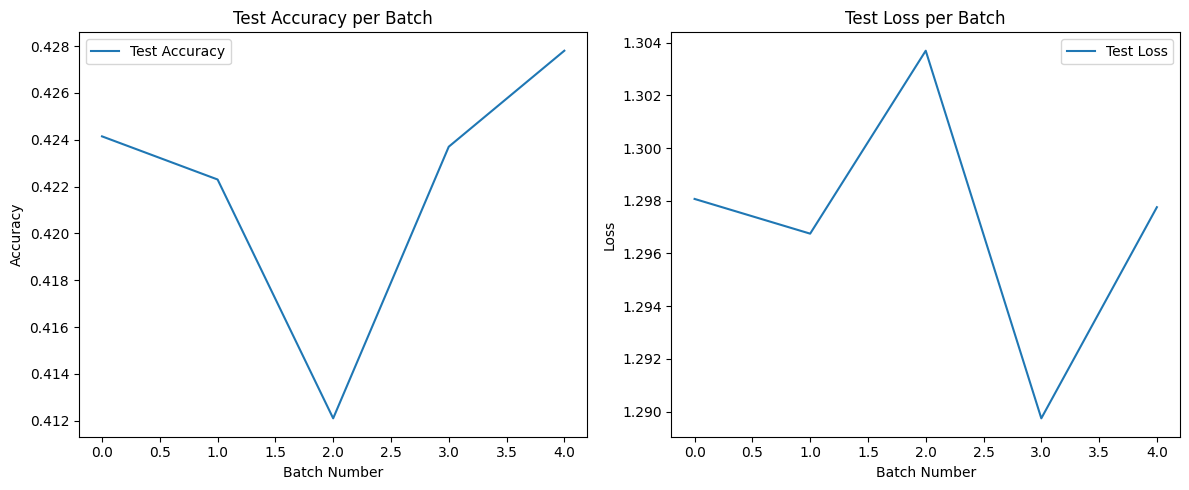

In [13]:
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

def test_model_and_plot(test_file_path, loaded_model, batch_size=10000):
    # Initialize lists to store loss and accuracy for each batch
    losses = []
    accuracies = []

    # Read the file in chunks
    for chunk in pd.read_csv(test_file_path, chunksize=batch_size, header=None):
        # Extract embeddings and ratings
        chunk_embeddings = chunk.iloc[:, :-1].values
        chunk_ratings = chunk.iloc[:, -1]

        # Convert ratings to numeric, handle NaNs
        chunk_ratings = pd.to_numeric(chunk_ratings, errors='coerce')
        chunk_embeddings = chunk_embeddings[chunk_ratings.notna()]
        chunk_ratings = chunk_ratings[chunk_ratings.notna()]

        # Adjust ratings for zero-based indexing
        chunk_ratings = chunk_ratings.astype(int) - 1

        # Convert ratings to categorical
        chunk_ratings_categorical = tf.keras.utils.to_categorical(chunk_ratings, num_classes=5)

        # Evaluate the model on the current batch
        batch_loss, batch_accuracy = loaded_model.evaluate(chunk_embeddings, chunk_ratings_categorical, verbose=0)
        losses.append(batch_loss)
        accuracies.append(batch_accuracy)

    # Plotting the accuracy and loss
    plt.figure(figsize=(12, 5))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(accuracies, label='Test Accuracy')
    plt.title('Test Accuracy per Batch')
    plt.xlabel('Batch Number')
    plt.ylabel('Accuracy')
    plt.legend(loc='best')

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(losses, label='Test Loss')
    plt.title('Test Loss per Batch')
    plt.xlabel('Batch Number')
    plt.ylabel('Loss')
    plt.legend(loc='best')

    plt.tight_layout()
    plt.show()

# Path to your test file
test_file_path = "/content/drive/MyDrive/CloudxLab/df_test.csv"
loaded_model = tf.keras.models.load_model('/content/drive/MyDrive/CloudxLab/LLM-Basic-ANN.h5')

# Test the model and plot the results
test_model_and_plot(test_file_path, loaded_model, batch_size=10000)